In [1]:
import scanpy as sc
import pandas as pd

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np
import gdown

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(6, 6))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)


Global seed set to 0


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("[*] Selected device: ", device)


[*] Selected device:  cuda


In [5]:
M1_data = sc.read_h5ad('M1_counts.h5ad')
M1_data

AnnData object with n_obs × n_vars = 305638 × 15680
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features'

In [6]:
target_species = ['human']

In [7]:
source_adata = M1_data[~M1_data.obs.species.isin(target_species)].copy()
target_adata = M1_data[M1_data.obs.species.isin(target_species)].copy()
print(source_adata)
print(target_adata)


AnnData object with n_obs × n_vars = 229017 × 15680
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features'
AnnData object with n_obs × n_vars = 76621 × 15680
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features'


In [8]:
del M1_data

In [9]:
source_adata.raw = source_adata
source_adata

AnnData object with n_obs × n_vars = 229017 × 15680
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features'

In [10]:
sc.pp.normalize_total(source_adata)
sc.pp.log1p(source_adata)

In [11]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="species",
    subset=True)


... storing 'Class' as categorical
... storing 'Subclass' as categorical
... storing 'RNA_cluster' as categorical
... storing 'Cross_species' as categorical
... storing 'species' as categorical
C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

### SCVI model

In [11]:
sca.models.SCVI.setup_anndata(source_adata, batch_key="species")


INFO     Using batches from adata.obs["species"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 229017 cells, 2000 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [12]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none",
)


In [13]:
vae.train(max_epochs=500)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|████████████| 500/500 [2:11:56<00:00, 15.83s/it, loss=956, v_num=1]


In [14]:
ref_latent = sc.AnnData(vae.get_latent_representation())
ref_latent.obs["species"] = source_adata.obs["species"].tolist()
ref_latent.obs["Class"] = source_adata.obs["Class"].tolist()
ref_latent.obs["Subclass"] = source_adata.obs["Subclass"].tolist()
ref_latent.obs["RNA_cluster"] = source_adata.obs["RNA_cluster"].tolist()
ref_latent.obs["Cross_species"] = source_adata.obs["Cross_species"].tolist()


In [15]:
sc.pp.neighbors(ref_latent, n_neighbors=8)
sc.tl.leiden(ref_latent)
sc.tl.umap(ref_latent)


... storing 'species' as categorical
... storing 'Class' as categorical
... storing 'Subclass' as categorical
... storing 'RNA_cluster' as categorical
... storing 'Cross_species' as categorical


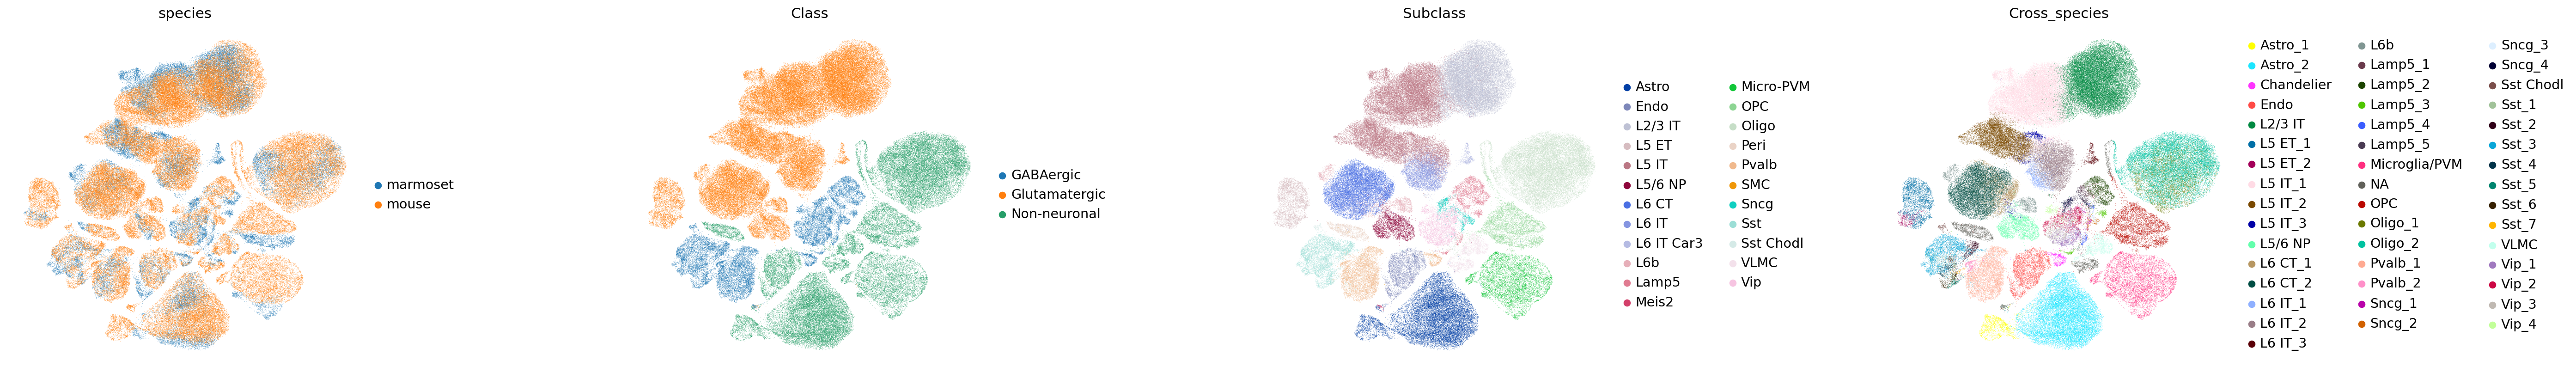

In [16]:
sc.pl.umap(ref_latent,
           color=['species', 'Class', 'Subclass', 'Cross_species'],
           frameon=False,
           wspace=0.6,
           )


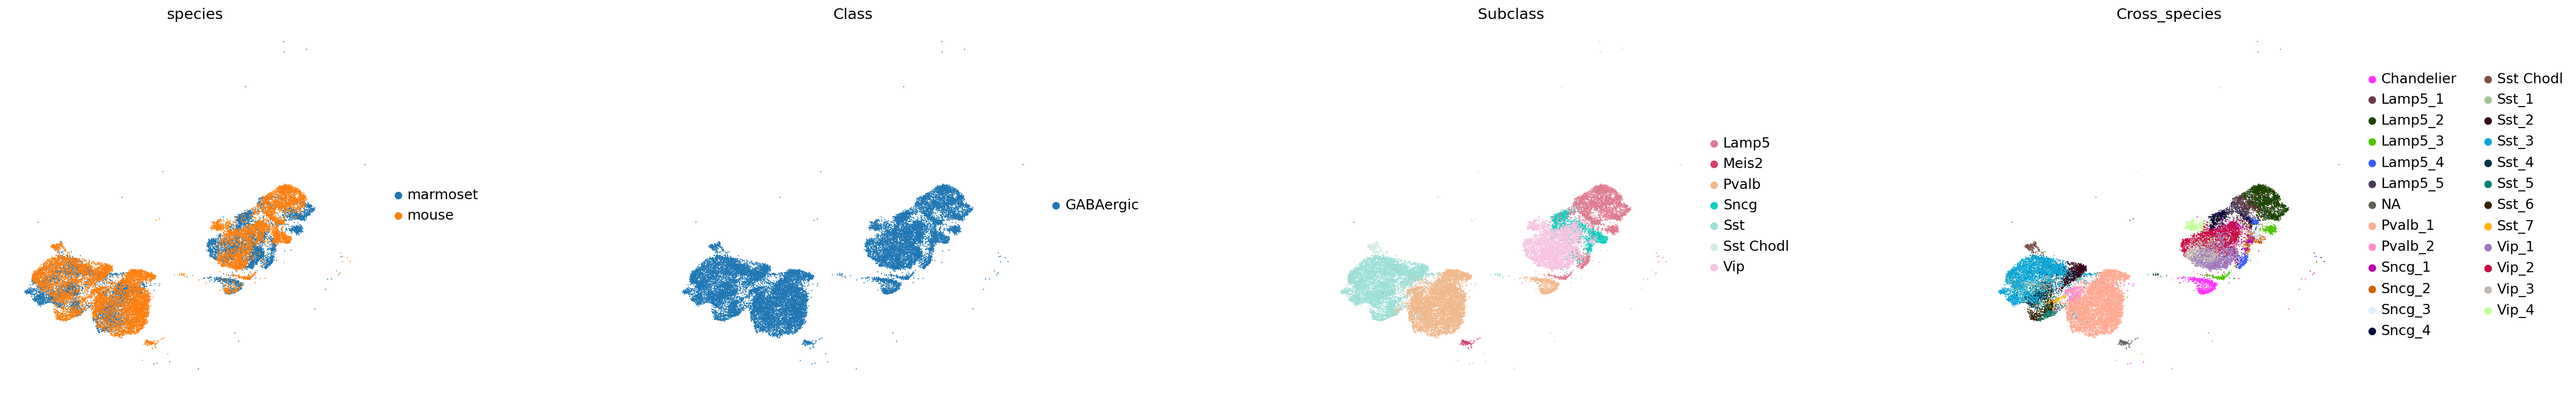

In [17]:
idx = np.where(ref_latent.obs['Class'] == 'GABAergic')[0]
sc.pl.umap(ref_latent[idx],
           color=['species', 'Class', 'Subclass', 'Cross_species'],
           frameon=False,
           wspace=0.6,
           )


In [15]:
ref_path = 'ref_model_M1/'
# vae.save(ref_path, overwrite=True)

In [19]:
ref_latent.write('ref_model_M1/ref_latent.h5ad')

In [16]:
ref_latent = sc.read('ref_model_M1/ref_latent.h5ad')

### Construct hierarchy for reference using scHPL

Use only GABAergic neurons only to make the results less cluttered

In [20]:
idx = np.where(ref_latent.obs['Class'] == 'GABAergic')[0]
ref_latent_GABA = ref_latent[idx]

In [21]:
ref_latent_GABA.obs['subclass_batch'] = np.char.add(np.array(ref_latent_GABA.obs['Subclass'], dtype= str),
                                             np.array(ref_latent_GABA.obs['species'], dtype=str))


Trying to set attribute `.obs` of view, copying.


Starting tree:


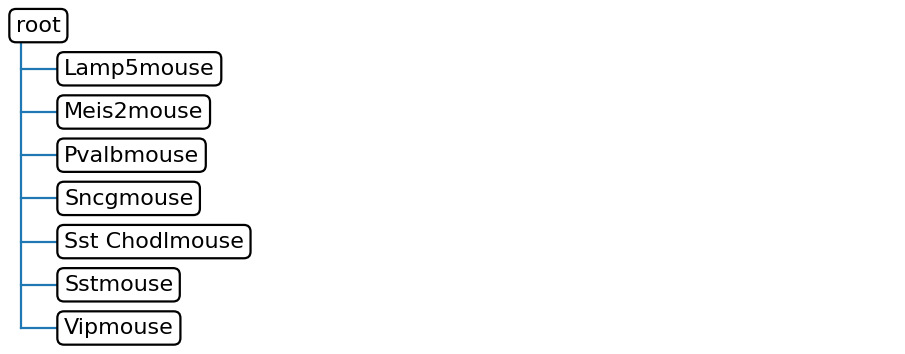


Adding dataset marmoset to the tree

Updated tree:


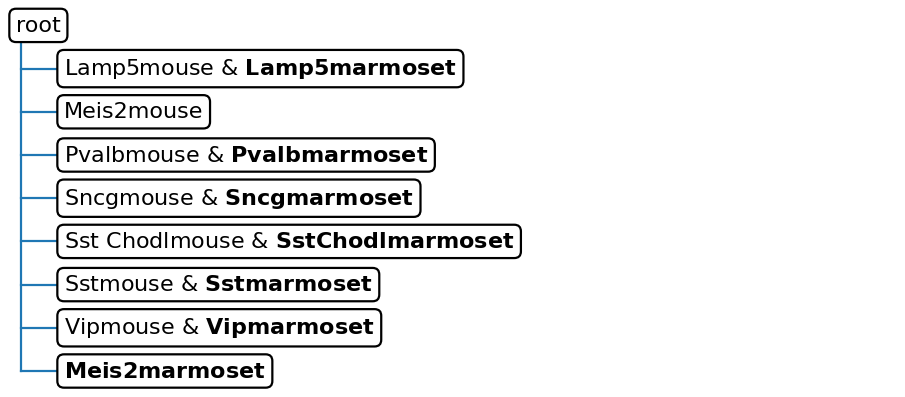

In [22]:
tree_ref, mp_ref = sca.classifiers.scHPL.learn_tree(data = ref_latent_GABA, 
                batch_key = 'species',
                batch_order = ['mouse', 'marmoset'],
                cell_type_key='subclass_batch',
                classifier = 'knn')


In [23]:
print(mp_ref)

[]


... storing 'subclass_batch' as categorical


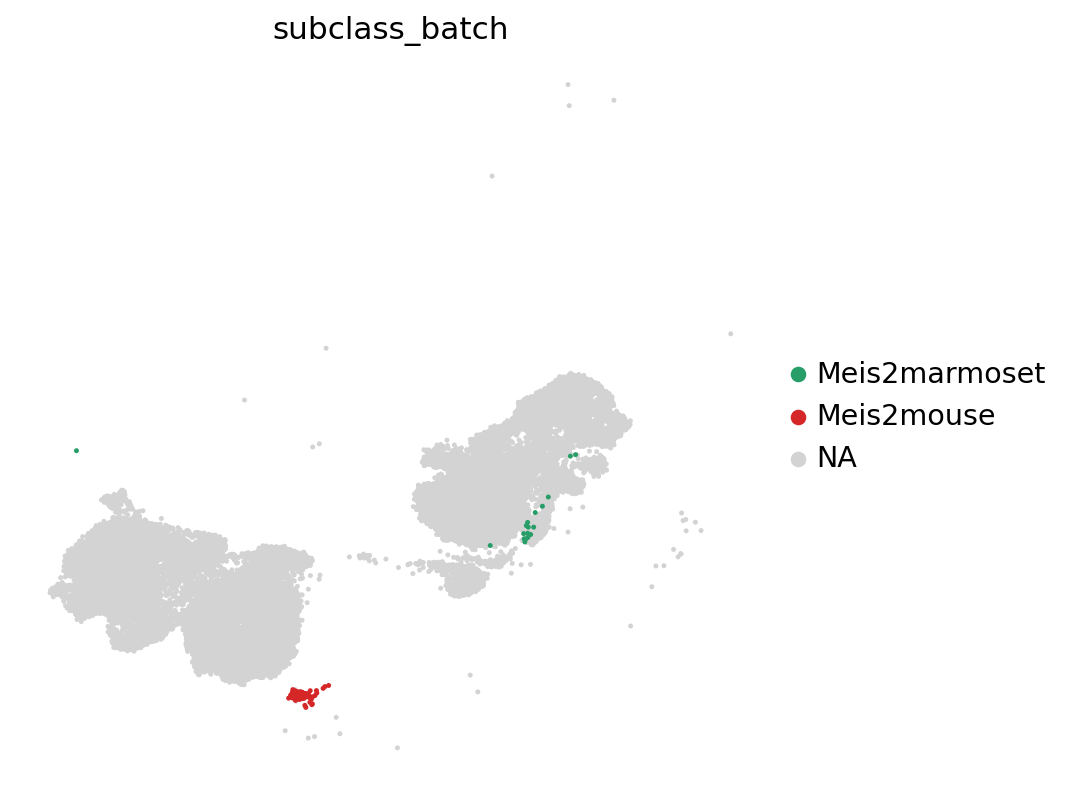

In [24]:
sc.pl.umap(ref_latent_GABA,
           color=['subclass_batch'],
           groups=['Meis2marmoset','Meis2mouse'],
           frameon=False,
           wspace=0.6,
           s=20
           )


### Apply surgery with human dataset

In [13]:
target_adata = target_adata[:, source_adata.var_names]
target_adata


View of AnnData object with n_obs × n_vars = 76621 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features'

In [17]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)


Trying to set attribute `.uns` of view, copying.


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 76621 cells, 2000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [18]:
model.train(max_epochs=100)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|█████████████████████████████████████████| 100/100 [10:34<00:00,  6.34s/it, loss=1.56e+03, v_num=1]


In [19]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs["species"] = target_adata.obs["species"].tolist()
query_latent.obs["Class"] = target_adata.obs["Class"].tolist()
query_latent.obs["Subclass"] = target_adata.obs["Subclass"].tolist()
query_latent.obs["RNA_cluster"] = target_adata.obs["RNA_cluster"].tolist()
query_latent.obs["Cross_species"] = target_adata.obs["Cross_species"].tolist()


In [20]:
surgery_path = 'surgery_model_M1'
model.save(surgery_path, overwrite=True)


In [21]:
full_latent = ref_latent.concatenate(query_latent,
                                           batch_key = 'ref_query')

... storing 'species' as categorical
... storing 'Class' as categorical
... storing 'Subclass' as categorical
... storing 'RNA_cluster' as categorical
... storing 'Cross_species' as categorical


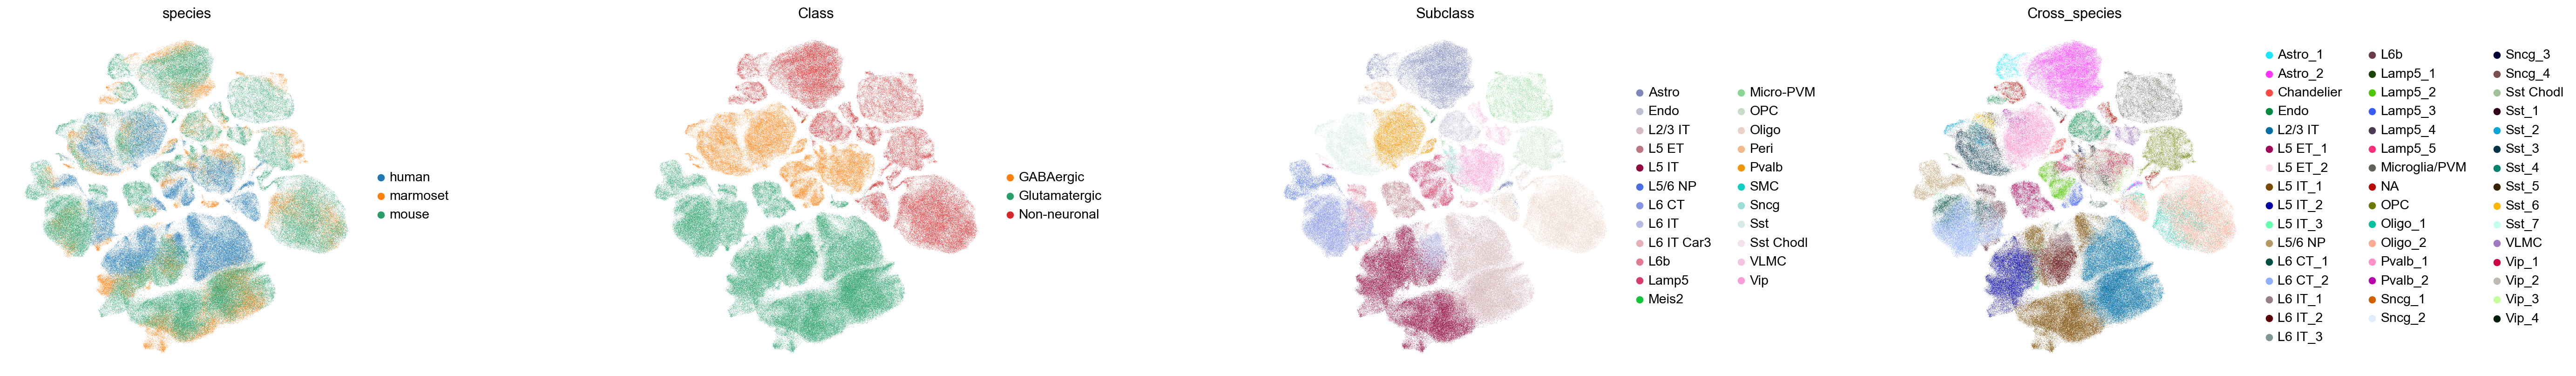

In [22]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['species', 'Class', 'Subclass', 'Cross_species'],
           frameon=False,
           wspace=0.6,
           )


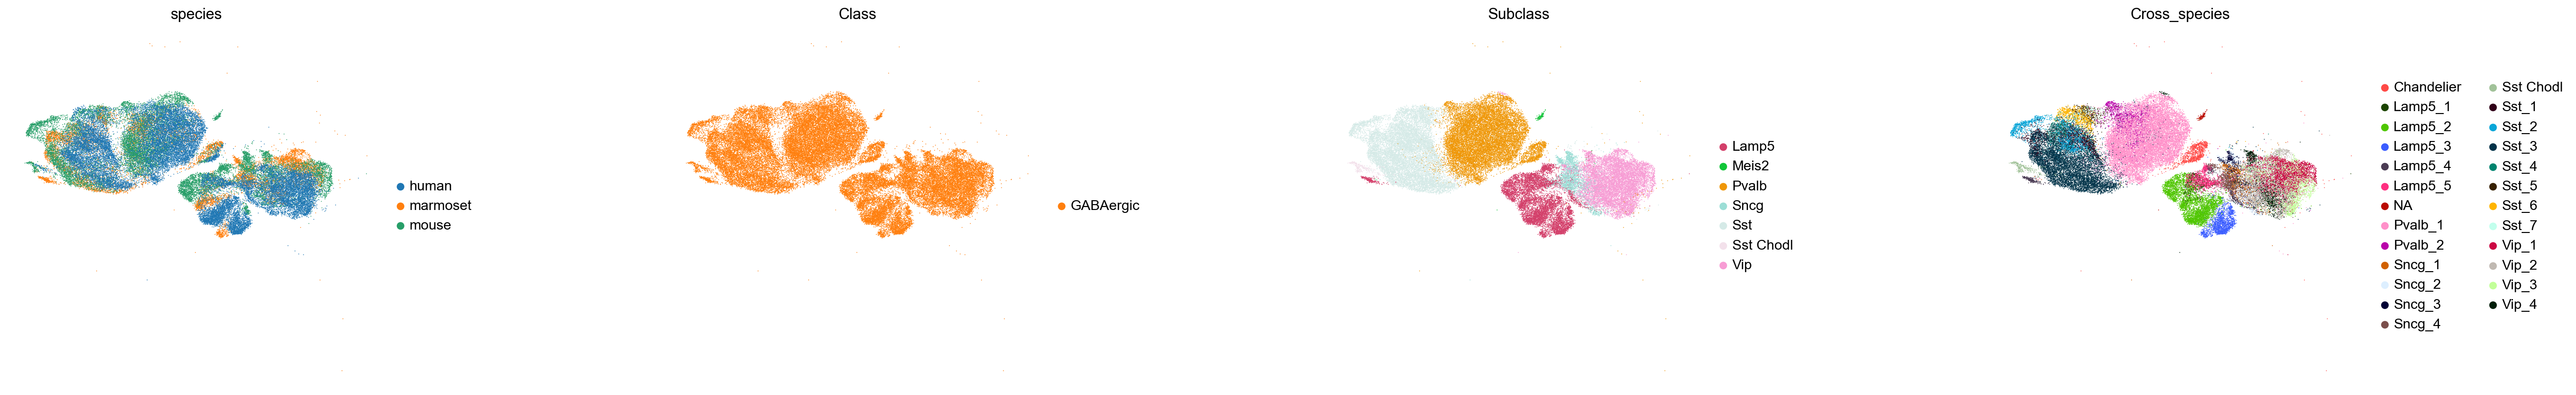

In [25]:
idx = np.where(full_latent.obs['Class'] == 'GABAergic')[0]
sc.pl.umap(full_latent[idx],
           color=['species', 'Class', 'Subclass', 'Cross_species'],
           frameon=False,
           wspace=0.6,
           )


In [24]:
full_latent.write('surgery_model_M1/full_latent.h5ad')

### Add human dataset to the tree

In [34]:
idx = np.where(full_latent.obs['Class'] == 'GABAergic')[0]
full_latent_GABA = full_latent[idx]



In [35]:
full_latent_GABA.obs['subclass_batch'] = np.char.add(np.array(full_latent_GABA.obs['Subclass'], dtype= str),
                                             np.array(full_latent_GABA.obs['species'], dtype=str))


Trying to set attribute `.obs` of view, copying.


Starting tree:


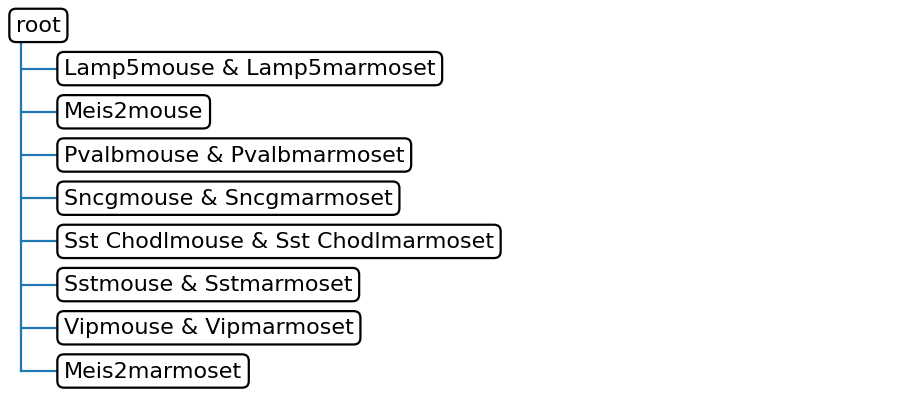


Adding dataset human to the tree

Updated tree:


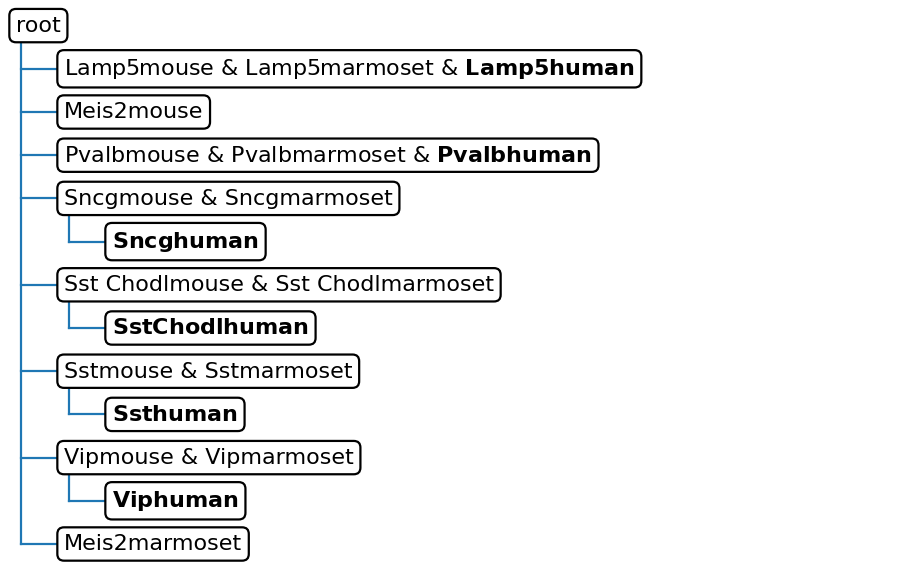

In [36]:
tree_full, mp_full = sca.classifiers.scHPL.learn_tree(data = full_latent_GABA, 
                batch_key = 'species',
                batch_added = ['mouse', 'marmoset'],
                batch_order = ['human'],
                cell_type_key='subclass_batch',
                retrain = False,
                tree = tree_ref,
                classifier = 'knn')

In [37]:
print(mp_full)

[]
